Crea automáticamente un mosaico a partir de las imágenes en una carpeta.
Las imágenes no tienen por qué estar ordenadas ni formar una cadena lineal y
no sabemos el espacio que ocupa el resultado.
El usuario debe intervenir lo menos posible.
Recuerda que debe tratarse de una escena plana o de una escena cualquiera vista desde el mismo centro de proyección.
Debes usar homografías. Compara el resultado con el que obtiene la utilidad de stitching de OpenCV.


In [1]:
import numpy as np
import cv2   as cv

import matplotlib.pyplot as plt
import numpy.linalg      as la

from ipywidgets          import interactive
from matplotlib.pyplot import imshow, title
%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

#mpl.rcParams['figure.dpi'] = 180
def readrgb(file):
    img = cv.imread(file)
    return img,cv.cvtColor( img, cv.COLOR_BGR2RGB)

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def imshowg(x):
    plt.imshow(x, "gray")




# dibuja un polígono cuyos nodos son las filas de un array 2D
def shcont(c, color='blue', nodes=True):
    x = c[:,0]
    y = c[:,1]
    x = np.append(x,x[0])
    y = np.append(y,y[0])
    plt.plot(x,y,color)
    if nodes: plt.plot(x,y,'.',color=color, markerSize=11)
def desp(d):
    dx,dy = d
    return np.array([
            [1,0,dx],
            [0,1,dy],
            [0,0,1]])

Cargamos las imagenes

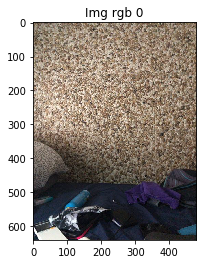

In [13]:
import glob

imgs = [readrgb(x) for x in sorted(glob.glob('../img/PANO/habitacion/*'))]
# Esto es una maravilla
imgs_bgr,img_rgb = zip(*imgs)
#img1,m_img1 = readrgb("1.JPEG")
#img2,m_img2 = readrgb("2.JPEG")
#img2,m_img3 = readrgb("3.JPEG")
imshow(img_rgb[0]); title('Img rgb 0');



Creamos el switcher


In [14]:
stitcher = cv.Stitcher.create(mode=cv.Stitcher_PANORAMA)
status, pano = stitcher.stitch(imgs_bgr)

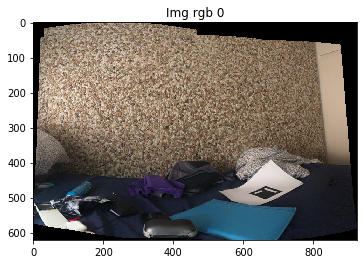

In [15]:
imshow(cv.cvtColor( pano, cv.COLOR_BGR2RGB)); title('Img rgb 0');

Vamos a usar ahora homografias para esto necesitamos usar puntos shift para encontrar los puntos que sean iguales en varias imagenes y luego poder mover el plano de todas las imagenes al mismo.



In [16]:
# utilidad para devolver el número de correspondencias y la homografía entre dos imágenes

sift = cv.AKAZE_create()
bf = cv.BFMatcher()

def match(query, model):
    x1 = query
    x2 = model
    (k1, d1) = sift.detectAndCompute(x1, None)
    (k2, d2) = sift.detectAndCompute(x2, None)
    
    matches = bf.knnMatch(d1,d2,k=2)
    # ratio test
    good = []
    for m in matches:
        if len(m) == 2:
            best, second = m
            if best.distance < 0.75*second.distance:
                good.append(best)
    
    #if len(good) < 6: return 6, None
    
    src_pts = np.array([ k2[m.trainIdx].pt for m in good ]).astype(np.float32).reshape(-1,2)
    dst_pts = np.array([ k1[m.queryIdx].pt for m in good ]).astype(np.float32).reshape(-1,2)
    
    H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 3)
    
    return sum(mask.flatten()>0), H

In [17]:
print(match(img_rgb[0],img_rgb[1]))

(1158, array([[ 9.80847955e-01,  1.56327533e-02, -1.09419063e+01],
       [-2.55053681e-02,  9.56515038e-01,  3.50925052e+01],
       [ 1.42211568e-05, -6.42826982e-05,  1.00000000e+00]]))


In [18]:
sorted([(match(p,q)[0],i,j) for i,p in enumerate(img_rgb) for j,q in enumerate(img_rgb) if i< j],reverse=True)

[(1158, 0, 1),
 (831, 3, 4),
 (704, 0, 2),
 (675, 1, 2),
 (562, 2, 3),
 (509, 4, 5),
 (342, 2, 4),
 (310, 3, 5),
 (293, 1, 3),
 (288, 0, 3),
 (159, 0, 4),
 (150, 1, 4),
 (90, 2, 5),
 (0, 1, 5),
 (0, 0, 5)]

Creamos la imagen base desplazandola al centro y haciendola mas grande

Vamos añadiendo las que tengan más correspondencias con alguna anterior.

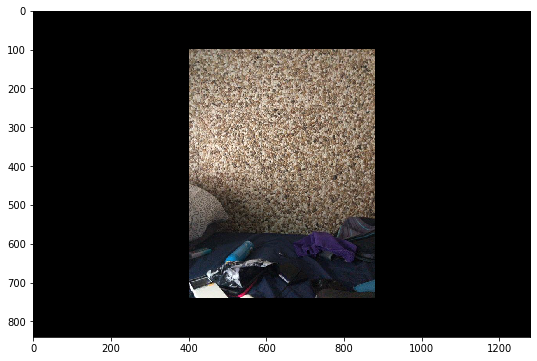

In [19]:
h,w,_ = img_rgb[0].shape
mw,mh = 400,100
T = desp((mw,float(mh)))
sz = (w+2*mw,h+2*mh)
base = cv.warpPerspective(img_rgb[0], T , sz)

fig(10,6)
plt.imshow(base);

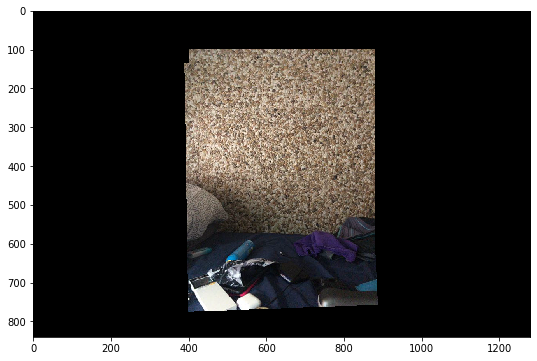

In [20]:
_,H01 = match(img_rgb[0],img_rgb[1])
cv.warpPerspective(img_rgb[1],T@H01,sz, base, 0, cv.BORDER_TRANSPARENT)
fig(10,6)
plt.imshow(base);

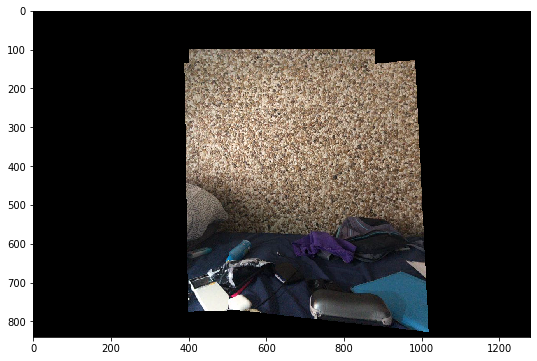

In [21]:
_,H02 = match(img_rgb[0],img_rgb[2])
cv.warpPerspective(img_rgb[2],T@H02,sz, base, 0, cv.BORDER_TRANSPARENT)
fig(10,6)
plt.imshow(base);

Ahora sólo tengo que automatizar este proceso, para eso creo una función que empareje por orden.
Podría hacerse de varias maneras, una de estas puede ser:

In [11]:
def createPanoramic(img_rgbs):
    value ,x ,y = sorted([(match(p,q)[0],i,j) for i,p in enumerate(img_rgb) for j,q in enumerate(img_rgb) if i< j],reverse=True)[0]
    if value == 0 :
        print ("No podemos crear la panoramica")
        return False
    # Creamos la base
    h,w,_ = img_rgb[x].shape
    mw,mh = 400,100
    T = desp((mw,float(mh)))
    sz = (w+2*mw,h+2*mh)
    base = cv.warpPerspective(img_rgb[x], T , sz)
    
    _,Hxy = match(img_rgb[x],img_rgb[y])
    cv.warpPerspective(img_rgb[1],T@Hxy,sz, base, 0, cv.BORDER_TRANSPARENT)

    while value !=0 or len(img_rgb) == 0:
        del img_rgb[x]
        del img_rgb[y]
        img_rgb
        value ,x ,y = sorted([(match(p,q)[0],i,j) for i,p in enumerate(img_rgb) for j,q in enumerate(img_rgb) if i< j],reverse=True)[0]

        _,H01 = match(img_rgb[0],img_rgb[1])
        cv.warpPerspective(img_rgb[1],T@H01,sz, base, 0, cv.BORDER_TRANSPARENT)
        fig(10,6)
        plt.imshow(base);


    